Changing the value of j for the noise and blur selects the value at the index of j from the array of values taken from the paper. (0 <= j <= 5)

training sets are distorted with random values for blur and noise (depending on the network) while the training set is blurred/added noise with the same value of sigma or variance

e.g. sigma_values[0] means a sigma value of zero (no blurring)

**ANY DISTORTIONS MADE TO THE MNIST DATASET MUST BE RESET BY RE-DOWNLOADING MNIST AND ADDING THE DATASET TO THE TRAINING AND TEST SETS.**

**NOTE THAT DISTORTIONS STACK! RUNNING THE DISTORTIONS TWICE IN A ROW WILL DISTORT THE DISTORTION!**

The code below:

1. Downloads the MNIST dataset, adding it to a training and test set.

2. Builds and trains a normal (contorl) ANN using the parameters from the paper.

3. Tests the control ANN

4. Saves the control ANN weights and biases

5. Adds gaussian blur to the MNIST training and test set (RESET MAY BE NEEDED)

6. Builds and trains a second ANN using the weights and biases of the control ANN on the blurred MNIST data sets

7. Tests the blurred ANN

8. Saves the blurred ANN weights and biases

9. Adds gaussian noise to the MNIST training and test set (RESET MAY BE NEEDED)

10. Builds and trains a third ANN using the weights and biases of the control ANN on the noisy MNIST data sets

11. Tests the noisy ANN

12. Saves the noisy ANN weights and biases







In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

In [2]:
# Download MNIST dataset
from torchvision.datasets import MNIST


In [5]:
import torchvision.transforms as trans

# flatten MNIST 28*28 images to a 784 vector for each image
transform = trans.Compose([
    trans.ToTensor(),  # convert to tensor
    trans.Lambda(lambda x: x.view(-1))  # flatten into vector
])

In [6]:
# RE-RUN CELL TO RESET DISTORTIONS MADE TO MNIST DATASET #

# load MNIST data into training and test sets
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)
trainset.data = trainset.data[0:27105]
trainset.targets = trainset.targets[0:27105]

In [35]:
from torch.utils.data import DataLoader

# Create the data loaders for the training and test sets
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

In [6]:
import torch.nn.functional as F
from torch import nn

# Define the ANN
class NetworkControl(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NetworkControl, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = F.dropout(out, 0.2)        
        out = self.fc2(out)        
        out = F.relu(out)
        out = F.dropout(out, 0.2)        
        out = self.fc3(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out
  

In [7]:
import torchbearer
from torch import optim
from torchbearer.callbacks import LiveLossPlot

# install livelossplot 
!pip install livelossplot

# utilize the GPU if one exists, otherwise use the CPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# initialize control network
model = NetworkControl(784, 1200, 10)

# define the loss function
loss_function = nn.CrossEntropyLoss()
# define the optimiser, learning rate and momentum
optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

# create a live loss plot of accuracy and loss after each training epoch
plot = LiveLossPlot()

# train the network using model, optimiser and loss function for 2 epochs
trial = torchbearer.Trial(model, optimiser, loss_function, callbacks=[plot], metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
trial.run(epochs=2)

<Figure size 1200x1200 with 4 Axes>

[{'running_loss': 0.32762107253074646,
  'running_acc': 0.9037500023841858,
  'loss': 0.6747522354125977,
  'acc': 0.8122117519378662,
  'train_steps': 212,
  'validation_steps': None},
 {'running_loss': 0.2374526858329773,
  'running_acc': 0.9328124523162842,
  'loss': 0.2621101438999176,
  'acc': 0.9248477816581726,
  'train_steps': 212,
  'validation_steps': None}]

In [17]:
# save the trained model
torch.save(model.state_dict(),"control.pth")


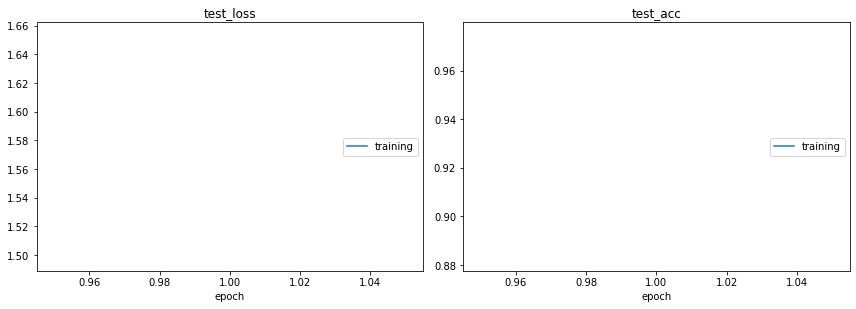

Test Loss:	 1.5756337642669678
Test Accuracy:	 0.9286999702453613


In [12]:
# print the accuracy and loss of control network on the MNIST test data
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print("Test Loss:\t", results.get("test_loss"))
print("Test Accuracy:\t", results.get("test_acc"))

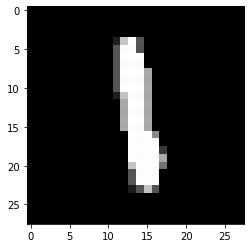

In [29]:
from scipy.ndimage import gaussian_filter
import numpy as np
from matplotlib import pyplot as plt
import random

# Gaussian Blur Distortion on training set #

# store all potential sigma values taken from paper
sigma_values = [0, 0.5, 1.0, 1.5, 2.0, 2.5]

# function to blur each MNIST image
def blur(x, sig):
  return gaussian_filter(x, sigma=sig)

# Distort the training set #

for i in range(len(trainset)):
  # chosen a random value for sigma
  j = random.randint(0, 5)
  # gaussian blur the image with the chosen sigma value
  blurredImage = blur(trainset.train_data[i].numpy(), sigma_values[j])
  # update the training set with the blurred image
  trainset.train_data[i] = torch.from_numpy(blurredImage)

# display an example of distorted MNIST image from training set
plt.imshow(trainset.train_data[200], cmap=plt.get_cmap('gray'))
plt.show()

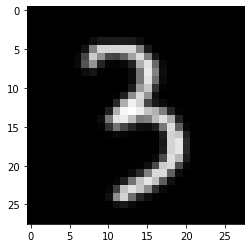

In [42]:
# Gaussian Blur Distortion on test set #

# store the index of the distortion sigma to use
j = 1

# Distort the test set #

for i in range(len(testset)):
  # gaussian blur the image with the chosen sigma value
  blurredImage = blur(testset.test_data[i].numpy(), sigma_values[j])
  # update the training set with the blurred image
  testset.test_data[i] = torch.from_numpy(blurredImage)

# display an example of distorted MNIST image from test set
plt.imshow(testset.test_data[205], cmap=plt.get_cmap('gray'))
plt.show()

In [43]:
from torch.utils.data import DataLoader

# Create the data loaders for the training and test sets
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

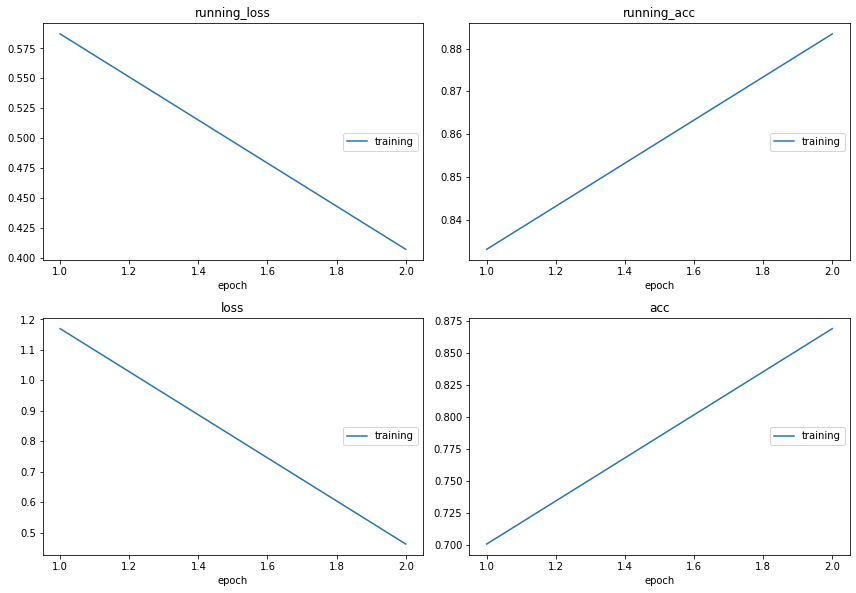

[{'running_loss': 0.5871942639350891,
  'running_acc': 0.8331249952316284,
  'loss': 1.1698887348175049,
  'acc': 0.7009776830673218,
  'train_steps': 212,
  'validation_steps': None},
 {'running_loss': 0.40706077218055725,
  'running_acc': 0.88343745470047,
  'loss': 0.4625542163848877,
  'acc': 0.868954062461853,
  'train_steps': 212,
  'validation_steps': None}]

In [44]:
import torchbearer
import pickle
from torch import optim
from torchbearer.callbacks import LiveLossPlot

# # install livelossplot 
# !pip install livelossplot

# utilize the GPU if one exists, otherwise use the CPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# train saved control network on blurred dataset 
model = NetworkControl(784, 1200, 10)
model.load_state_dict(torch.load("control.pth"))

# define the loss function
loss_function = nn.CrossEntropyLoss()
# define the optimiser, learning rate and momentum
optimiser = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)

# create a live loss plot of accuracy and loss after each training epoch
plot = LiveLossPlot()

# train the network using model, optimiser and loss function for 2 epochs
trial = torchbearer.Trial(model, optimiser, loss_function, callbacks=[plot], metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
trial.run(epochs=2)

In [45]:
# save the trained model
torch.save(model.state_dict(),"blur.pth")
torch.save(model,'save_blur.pkl')

d:\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type NetworkControl. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


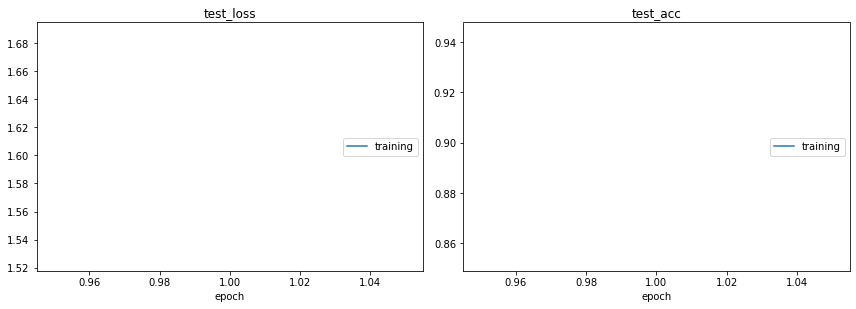

Test Loss:	 1.6061441898345947
Test Accuracy:	 0.8983999490737915


In [46]:
# print the accuracy and loss of blurred network on the MNIST test data
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print("Test Loss:\t", results.get("test_loss"))
print("Test Accuracy:\t", results.get("test_acc"))

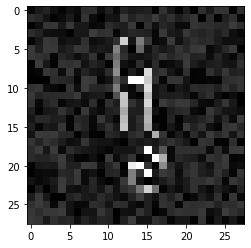

In [35]:
import numpy as np
from matplotlib import pyplot as plt
import random

# Gaussian Noise Distortion on training set #

# store all potential sigma values taken from paper
variance_values = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

# function to blur each MNIST image
def noise(x, var):
  return x + var * x.std() * np.random.random(x.shape)

# Distort the training set #

for i in range(len(trainset)):
  # chosen a random value for variance
  j = random.randint(0, 5)
  # add gaussian noise to the image with the chosen variance value
  noisyImage = noise(trainset.train_data[i].numpy(), variance_values[j])
  # update the training set with the noisy image
  trainset.train_data[i] = torch.from_numpy(noisyImage)

# display an example of distorted MNIST image from training set
plt.imshow(trainset.train_data[200], cmap=plt.get_cmap('gray'))
plt.show()

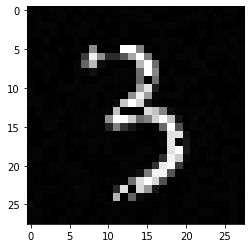

In [49]:
# Gaussian Noise Distortion on test set #

# store the index of the distortion variance to use
j = 1

# Distort the test set #

for i in range(len(testset)):
  # add gaussian noise to the image with the chosen variance value
  noisyImage = noise(testset.test_data[i].numpy(), variance_values[j])
  # update the training set with the noise image
  testset.test_data[i] = torch.from_numpy(noisyImage)

# display an example of distorted MNIST image from test set
plt.imshow(testset.test_data[205], cmap=plt.get_cmap('gray'))
plt.show()

In [50]:
from torch.utils.data import DataLoader

# Create the data loaders for the training and test sets
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

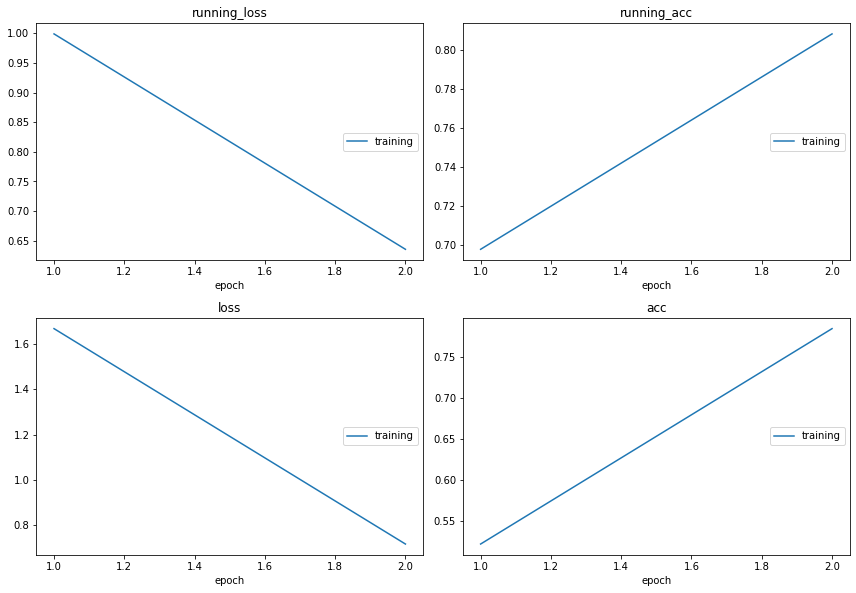

[{'running_loss': 0.9988030195236206,
  'running_acc': 0.6978124976158142,
  'loss': 1.6683669090270996,
  'acc': 0.5216749906539917,
  'train_steps': 212,
  'validation_steps': None},
 {'running_loss': 0.635664701461792,
  'running_acc': 0.8082812428474426,
  'loss': 0.715735673904419,
  'acc': 0.7845047116279602,
  'train_steps': 212,
  'validation_steps': None}]

In [51]:
import torchbearer
from torch import optim
from torchbearer.callbacks import LiveLossPlot

# install livelossplot 
!pip install livelossplot

# utilize the GPU if one exists, otherwise use the CPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# train control network on noisy training set
model = NetworkControl(784, 1200, 10)
model.load_state_dict(torch.load("control.pth"))

# define the loss function
loss_function = nn.CrossEntropyLoss()
# define the optimiser, learning rate and momentum
optimiser = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)

# create a live loss plot of accuracy and loss after each training epoch
plot = LiveLossPlot()

# train the network using model, optimiser and loss function for 2 epochs
trial = torchbearer.Trial(model, optimiser, loss_function, callbacks=[plot], metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
trial.run(epochs=2)

In [52]:
# save the trained model
torch.save(model.state_dict(),"noise.pth")
torch.save(model,'save_noise.pkl')

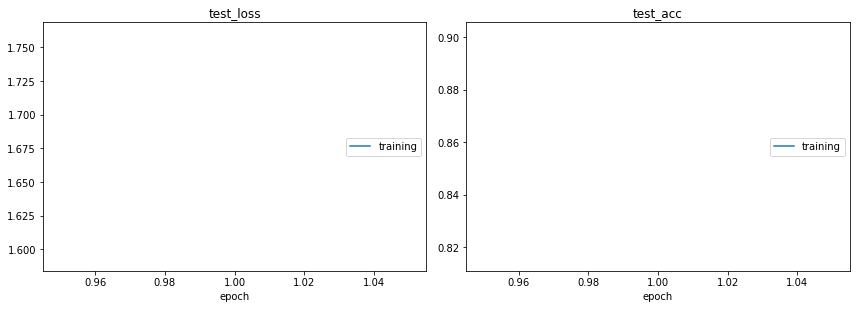

Test Loss:	 1.6762689352035522
Test Accuracy:	 0.858299970626831


In [53]:
# print the accuracy and loss of noisy network on the MNIST test data
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print("Test Loss:\t", results.get("test_loss"))
print("Test Accuracy:\t", results.get("test_acc"))